# Bernoulli VAEs for MNIST

After a short theory part in the introductory companion notebook, it is now time for a real demonstration. We therefore train two different VAEs with a Bernoulli likelihood on MNIST images. The trained models are then imported in this notebook and analyzed with regards to their latent space representation as well as their compression, reconstruction and generation capabilities.

A fully connected and a convolutional VAE can be trained by running the training script in the following ways:
```
python scripts/main.py fit --config config/mnist_dense.yaml

python scripts/main.py fit --config config/mnist_conv.yaml
```
The training can be monitored by `tensorboard --logdir run/`.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import torch
from lightning.pytorch import seed_everything

from varautoenc import(
    MNISTDataModule,
    ConvVAE,
    DenseVAE,
    generate,
    reconstruct,
    encode_loader
)

In [3]:
_ = seed_everything(111111)  # set random seeds manually

Seed set to 111111


## MNIST data

Note that, as we have previously discussed, the **standard Bernoulli distribution** is strictly speaking only applicable to $\{0,1\}$-valued data. In this case one would not need binarize the images beforehand. The **continuous Bernoulli distribution** establishes a technically valid choice for $[0,1]$-valued MNIST data. Nonetheless, we use the standard Bernoulli likelihood evaluated for continuous inputs, which amounts to discarding the normalization of the proper continuous density.

The class `MNISTDataModule` manages the datasets and loaders corresponding to our setup. The latter ones allow for generating mini-batches of data during training and inference. Even though some random rotations are used for data augmentation purposes, it is remarked that one might of course apply more sophisticated random digit-preserving image transformations.

In [4]:
mnist = MNISTDataModule(
    data_dir='../run/data/',
    binarize_threshold=None,
    mean=None,
    std=None,
    batch_size=32
)

mnist.prepare_data()  # download data if not yet done
mnist.setup(stage='test')  # create test set

In [5]:
test_loader = mnist.test_dataloader()
x_batch, y_batch = next(iter(test_loader))

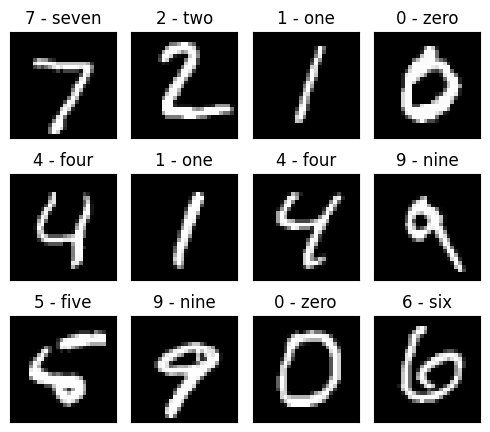

In [6]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(5, 4.5))
for idx, ax in enumerate(axes.ravel()):
    image = x_batch[idx, 0].numpy()
    ax.imshow(image, cmap='gray', vmin=0, vmax=1)
    ax.set_title(mnist.test_set.classes[y_batch[idx]])
    ax.set(xticks=[], yticks=[], xlabel='', ylabel='')
fig.tight_layout()

## Dense VAE (two-dim. latent space)

In a first experiment, we visualize the latent space of a densely connected VAE that is implemented in the class `DenseVAE`. The dimensionality of the latent space it set to only two. This is an arbitrary choice that facilitates the visual investigation of the encoding.

As per our setup, both encoder and decoder have four dense layers each. Leaky ReLU activation functions are used where appropriate. The images are flattened when being passed to the encoder and reshaped to the original resolution by the decoder.

A single Monte Carlo sample is used in order to estimate the objective for each data point. It was observed here that higher sample numbers have not improved convergence. The loss is noisy due to this and, as usual, the randomized mini-batching.

In [7]:
ckpt_file = '../run/mnist_dense/version_0/checkpoints/last.ckpt'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

dense_vae = DenseVAE.load_from_checkpoint(ckpt_file)

dense_vae = dense_vae.eval()
dense_vae = dense_vae.to(device)

In [8]:
print(f'Likelihood: {dense_vae.likelihood_type}')
print(f'Beta: {dense_vae.beta}')

try:
    sigma = dense_vae.decoder.dist_params.logsigma.exp().item()
    print(f'Sigma: {sigma:.4f}')
except AttributeError as e:
    pass

Likelihood: Bernoulli
Beta: 1.0


After importing a trained model, the encoder is, facilitated by the function `encode_loader`, applied to the whole test set. Since this actually yields diagonal Gaussian distributions, only the mean vectors are used as the encodings. The alternative would be to take the full distributions or to simply generate random samples from them.

In [9]:
z_mu, z_sigma, y = encode_loader(
    dense_vae,
    test_loader,
    return_targets=True
)

print('Latent mean: {:.2f}'.format(z_mu.mean()))
print('Latent std.: {:.2f}'.format(z_mu.std()))

Latent mean: -0.01
Latent std.: 1.07


We can now plot the computed points in the two-dimensional latent space. Points belonging to different digits have different colors. While the VAE has not processed any class label information during training, it is interesting to observe how the classes are organized in the latent space.

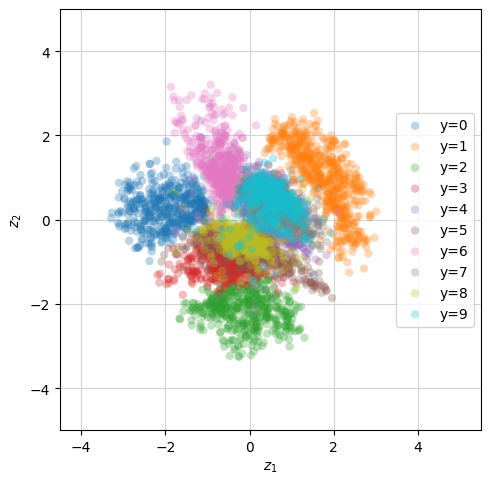

In [10]:
fig, ax = plt.subplots(figsize=(5, 5))
for idx in range(10):
    ax.scatter(
        z_mu[y==idx, 0][::2].numpy(),
        z_mu[y==idx, 1][::2].numpy(),
        color=plt.cm.tab10(idx),
        alpha=0.3,
        edgecolors='none',
        label='y={}'.format(idx)
    )
ax.set(xlabel='$z_1$', ylabel='$z_2$', xlim=(-4.5, 5.5), ylim=(-5, 5))
ax.set_aspect('equal', adjustable='box')
ax.legend(loc='center right')
ax.grid(visible=True, which='both', color='lightgray', linestyle='-')
ax.set_axisbelow(True)
fig.tight_layout()

## Conv. VAE (64-dim. latent space)

We investigate in a second experiment how to encode, reconstruct and generate data with the model class `ConvVAE` that utilizes both conv. and dense layers. While it takes significantly longer to train, the CNN-based architecture embodies certain prior assumptions (hierarchical representations, translation invariance) that are often reasonable in vision applications.

The encoder passes the input through two conv. layers before the features are flattened and subsequently passed through two dense layers. The latent representation comprises 64 variables. As far as possible, the decoder is constructed symmetrically. While the encoder contains standard downscaling operations, the decoder utilizes interpolation-based upscalings. Transposed convolutions would be an alternative, despite occasionally suffering from checkerboard artifacts. Again, a single-sample estimator of the loss and its gradient is employed. 

In [11]:
ckpt_file = '../run/mnist_conv/version_0/checkpoints/last.ckpt'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

checkpoint = torch.load(ckpt_file, map_location=device)
conv_vae = ConvVAE.load_from_checkpoint(ckpt_file)

conv_vae = conv_vae.eval()
conv_vae = conv_vae.to(device)

In [12]:
print(f'Likelihood: {conv_vae.likelihood_type}')
print(f'Beta: {conv_vae.beta}')

try:
    sigma = conv_vae.decoder.dist_params.logsigma.exp().item()
    print(f'Sigma: {sigma:.4f}')
except AttributeError as e:
    pass

Likelihood: Bernoulli
Beta: 1.0


In [13]:
z_mu, z_sigma = encode_loader(
    conv_vae,
    test_loader
)

print('Latent mean: {:.2f}'.format(z_mu.mean()))
print('Latent std.: {:.2f}'.format(z_mu.std()))

Latent mean: 0.01
Latent std.: 0.45


### Image reconstruction

Having imported a learned model, images can be compressed into their latent representation and subsequently be reconstructed. The function `reconstruct` computes the encoding while sampling is turned off. This means that the mean values of the Gaussian posterior form the encoding. The decoder is used on this latent code. Finally, the predicted Bernoulli probabilities constitute the image reconstruction.

In [14]:
x_batch, _ = next(iter(test_loader))
x_recon = reconstruct(conv_vae, x_batch, sample_mode=False)

A random sample of the binarized test images is shown in the first row of the following figure. The second row contains the corresponding reconstructions. We arrive at the conclusion that the reconstruction quality seems to be generally satisfactory

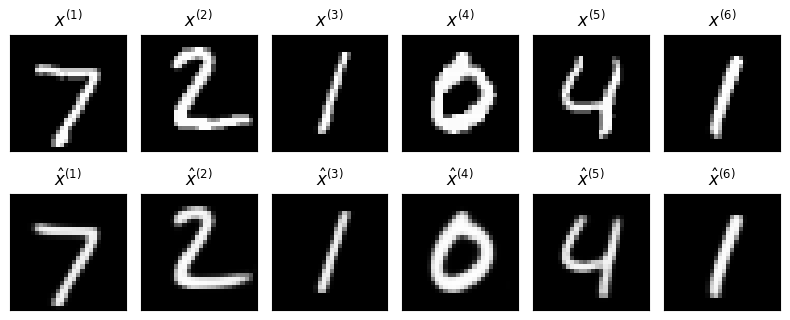

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(8, 3.5))

for idx, ax in enumerate(axes[0]):
    image = x_batch[idx, 0].numpy()
    ax.imshow(image, cmap='gray', vmin=0, vmax=1)
    ax.set_title('$x^{{({})}}$'.format(idx + 1))
    ax.set(xticks=[], yticks=[], xlabel='', ylabel='')

for idx, ax in enumerate(axes[1]):
    image = x_recon[idx, 0].numpy().clip(0, 1)
    ax.imshow(image, cmap='gray', vmin=0, vmax=1)
    ax.set_title('$\\hat{{x}}^{{({})}}$'.format(idx + 1))
    ax.set(xticks=[], yticks=[], xlabel='', ylabel='')

fig.tight_layout()

### Random generation

The function `generate` randomly generates new images. One hundred samples are drawn from the prior sampling distribution of the latent variables. This straightforward since the prior is just a diagonal Gaussian. Those latent values are subsequently passed to the decoder that predicts the Bernoulli probabilities. They are taken as the generated images without any further sampling (or thresholding).

In [16]:
num_samples = 25

num_latents = conv_vae.decoder.dense_layers[0][0].in_features
x_gen = generate(
    conv_vae,
    sample_shape=(num_latents,),
    num_samples=num_samples,
    random_seed=100000
)

While the results are certainly not perfect yet, the generated images look already quite realistic. A general weakness of VAE models is a certain "blurriness" of the results. This is not observed here though. Architectural improvements would likely enhance the generative modeling quality.

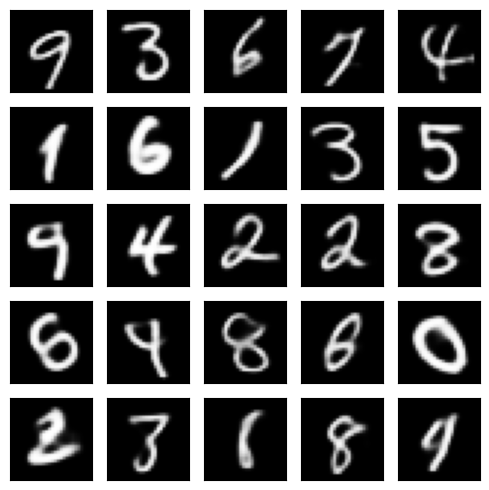

In [17]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(5, 5))
for idx, ax in enumerate(axes.ravel()):
    image = x_gen[idx, 0].numpy().clip(0, 1)
    ax.imshow(image, cmap='gray', vmin=0, vmax=1)
    ax.set(xticks=[], yticks=[], xlabel='', ylabel='')
fig.tight_layout()